In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing
import tensorflow as tf

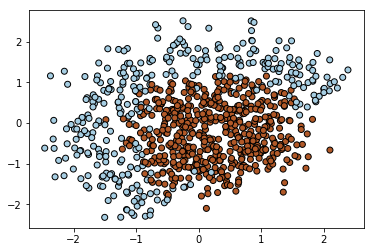

In [2]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Paired, c=y, edgecolors='black')

plt.show()

In [3]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, loss, n_iter):
    plt.clf()
    plt.figure(figsize=(20, 8))
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())


**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [4]:
def expand(X):
    X_ = tf.zeros((X.shape[0], 6))
    X0 = tf.transpose(tf.gather(tf.transpose(X), [0]))
    X1 = tf.transpose(tf.gather(tf.transpose(X), [1]))
    X_ = tf.concat([X, X ** 2, X0 * X1, tf.ones(shape=(X.shape[0], 1))], axis=1)
    return X_

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    
    y = tf.matmul(expand(X.astype(np.float32)), w[np.newaxis].T, name="y")
    sign = tf.squeeze(tf.sign(y), name="sign")
    out = tf.where(sign != 0, sign, tf.ones(X.shape[0])) 

    with tf.Session() as sess:
        print(out.eval())
        return out.eval()

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [5]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    
    y_pred = tf.matmul(expand(X), tf.transpose(w), name="y_pred")
    loss = tf.squeeze(1 - tf.multiply(y, tf.transpose(y_pred)), name="loss")
    out = tf.reduce_mean(tf.where(loss > 0, loss, tf.zeros(X.shape[0])))
    
    return out
    
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    
    y_t = tf.transpose(y, name="y_T")
    
    x = expand(X)
    y_pred = tf.matmul(x, tf.transpose(w), name="y_pred")
    loss = tf.squeeze(1 - y_t * y_pred, name="loss")
    x_new = tf.where(loss <= 0, tf.zeros(x.shape), -x * y_t, name="non_zero_grad")
    out = tf.reduce_mean(x_new, axis=0, name="grad")
    
    return out

### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

#### Build the computational graphs

In [6]:
batch_size = 4

X_in = tf.placeholder(tf.float32, shape=X.shape, name="X_in")
y_in = tf.placeholder(tf.float32, shape=(1, len(y)), name="y_in")
w_in = tf.placeholder(tf.float32, shape=(1, 6), name="w_in")

X_batch = tf.placeholder(tf.float32, shape=(batch_size, X.shape[1]), name="X_batch")
y_batch = tf.placeholder(tf.float32, shape=(1, batch_size), name="y_batch")
w_batch = tf.placeholder(tf.float32, shape=(1, 6), name="w_batch")

loss_node = compute_loss(X_in, y_in, w_in)
grad_node = compute_grad(X_batch, y_batch, w_batch)

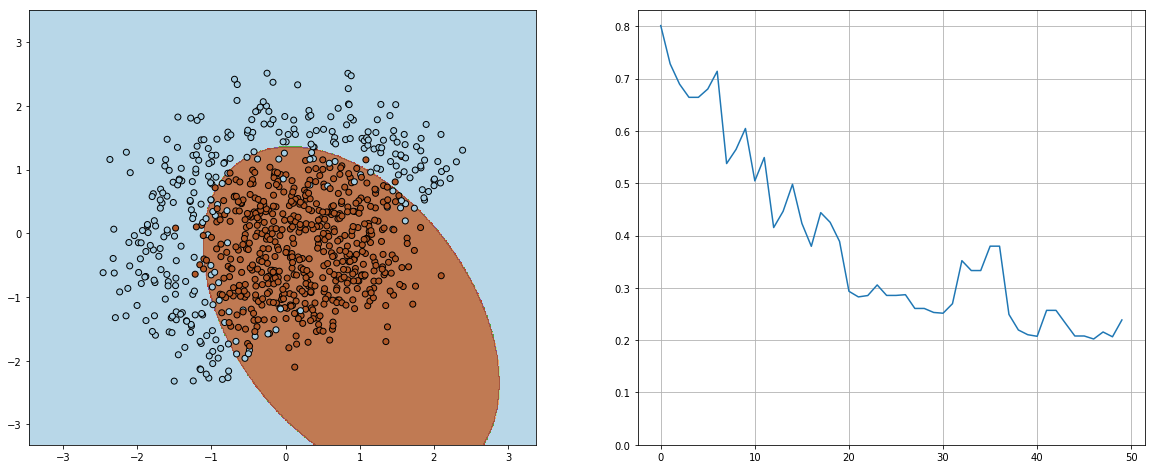

In [7]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)

alpha = 0.3

# alpha, loss
# 0.1, 0.25023752
# 0.2, 0.20030838
# 0.3, 0.17757332
# 0.5, 0.18125857
# 0.7, 0.16544935
# 0.9, 0.19494508

n_iter = 50
loss = np.zeros(n_iter)

plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)

        loss[i] = sess.run(loss_node, feed_dict={X_in: X,
                                                 y_in: y.reshape(1, len(y)),
                                                 w_in: w.reshape(1, 6)})

        grad = sess.run(grad_node, feed_dict={X_batch: X[ind, :], 
                                                       y_batch: y[ind].reshape(1, 4),
                                                       w_batch: w.reshape(1, 6)})
        
        w = w - alpha * grad
        
visualize(X, y, w, loss, n_iter)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

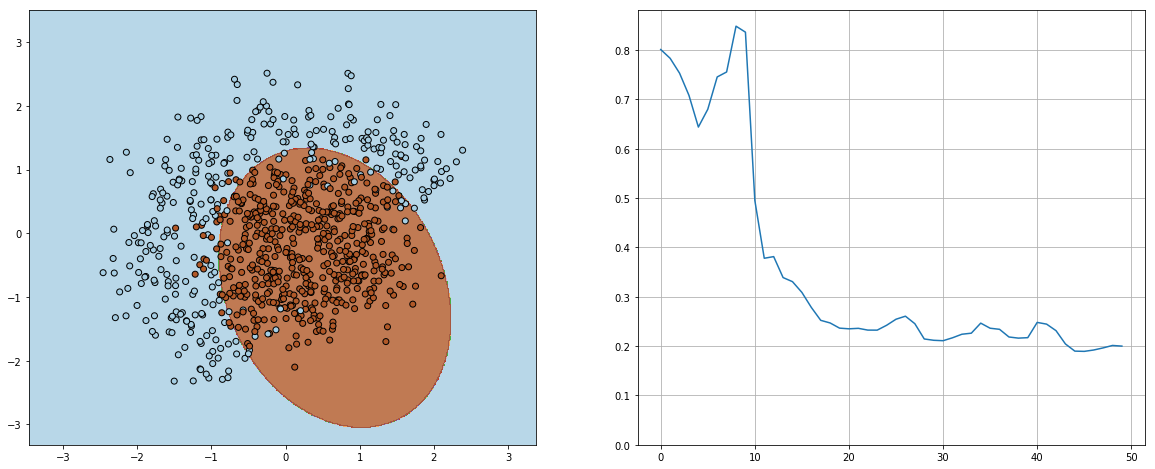

In [8]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)
v = 0.0

alpha = 0.2 # learning rate
mu    = 0.4 # momentum

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        loss[i] = sess.run(loss_node, feed_dict={X_in: X,
                                                 y_in: y.reshape(1, len(y)),
                                                 w_in: w.reshape(1, 6)})

        grad = sess.run(grad_node, feed_dict={X_batch: X[ind, :], 
                                                       y_batch: y[ind].reshape(1, 4),
                                                       w_batch: w.reshape(1, 6)})
        
        v = mu * v + alpha * grad
        w = w - v

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for Nesterov's accelerated gradient:

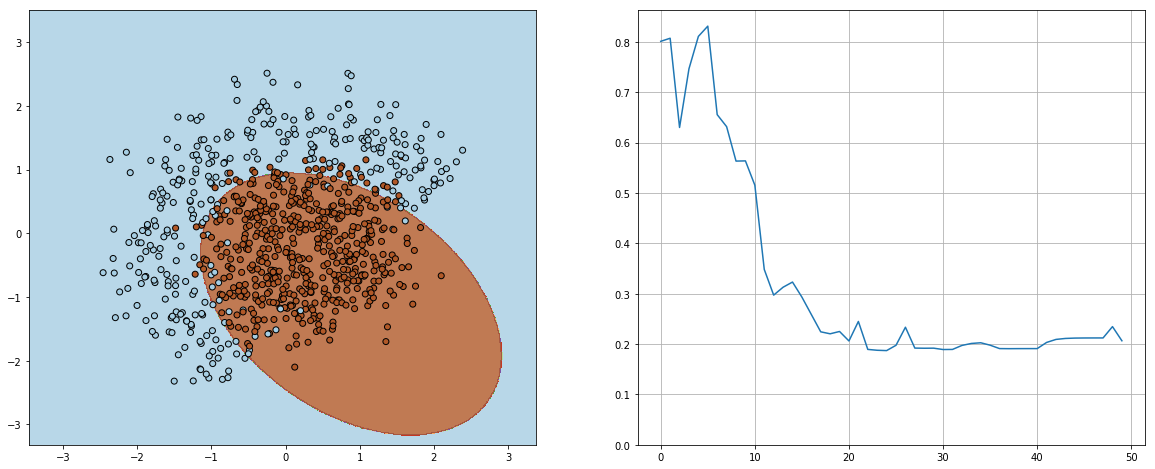

In [9]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)
v = 0.0

alpha = 0.4 # learning rate
mu    = 0.3 # momentum

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        loss[i] = sess.run(loss_node, feed_dict={X_in: X,
                                                 y_in: y.reshape(1, len(y)),
                                                 w_in: w.reshape(1, 6)})
        
        w_new = w - mu * v
        
        grad = sess.run(grad_node, feed_dict={X_batch: X[ind, :], 
                                                       y_batch: y[ind].reshape(1, 4),
                                                       w_batch: w_new.reshape(1, 6)})
        
        v = mu * v + alpha * grad
        w = w - v

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaGrad:

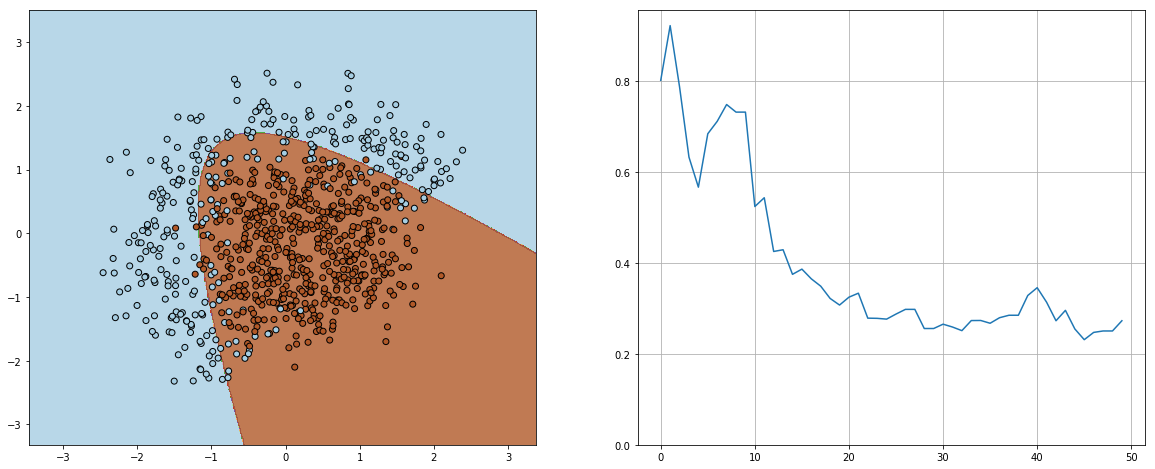

In [10]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)
c = np.zeros(shape=(6,), dtype=np.float32)

alpha = 0.4 # learning rate
eps = 1e-8  # A small constant for numerical stability

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        loss[i] = sess.run(loss_node, feed_dict={X_in: X,
                                                 y_in: y.reshape(1, len(y)),
                                                 w_in: w.reshape(1, 6)})
        
        grad = sess.run(grad_node, feed_dict={X_batch: X[ind, :], 
                                                       y_batch: y[ind].reshape(1, 4),
                                                       w_batch: w.reshape(1, 6)})
        
        c = c + grad ** 2
        w = w - alpha * grad / (np.sqrt(c + eps))

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaDelta:

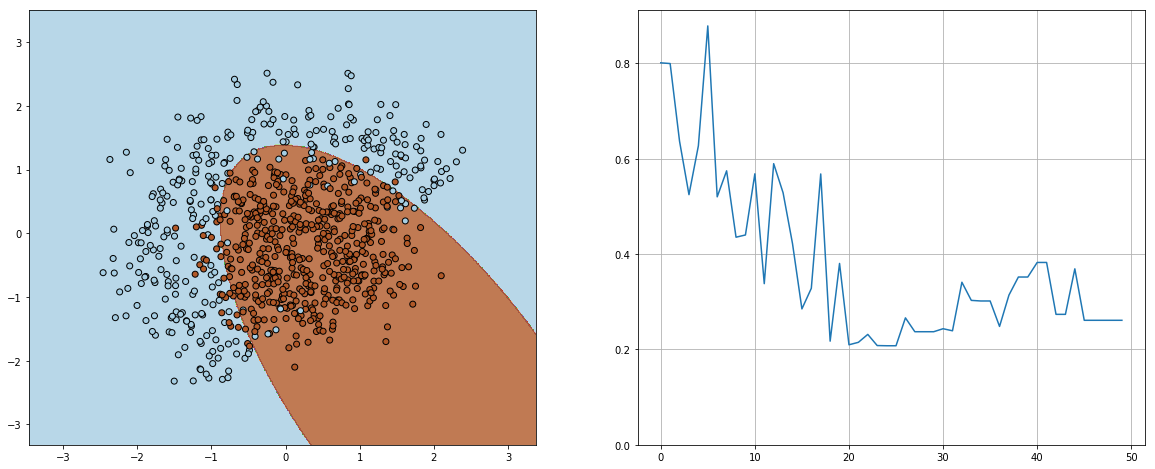

In [11]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)
c = np.zeros(shape=(6,), dtype=np.float32)

alpha = 0.3 # learning rate
beta = 0.6
eps = 1e-8  # A small constant for numerical stability

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        loss[i] = sess.run(loss_node, feed_dict={X_in: X,
                                                 y_in: y.reshape(1, len(y)),
                                                 w_in: w.reshape(1, 6)})
        
        grad = sess.run(grad_node, feed_dict={X_batch: X[ind, :], 
                                                       y_batch: y[ind].reshape(1, 4),
                                                       w_batch: w.reshape(1, 6)})
        
        c = beta * c + (1 - beta) * (grad ** 2)
        w = w - alpha * grad / (np.sqrt(c + eps))

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task for Adam algorithm. You can start with beta = 0.9 and mu = 0.999

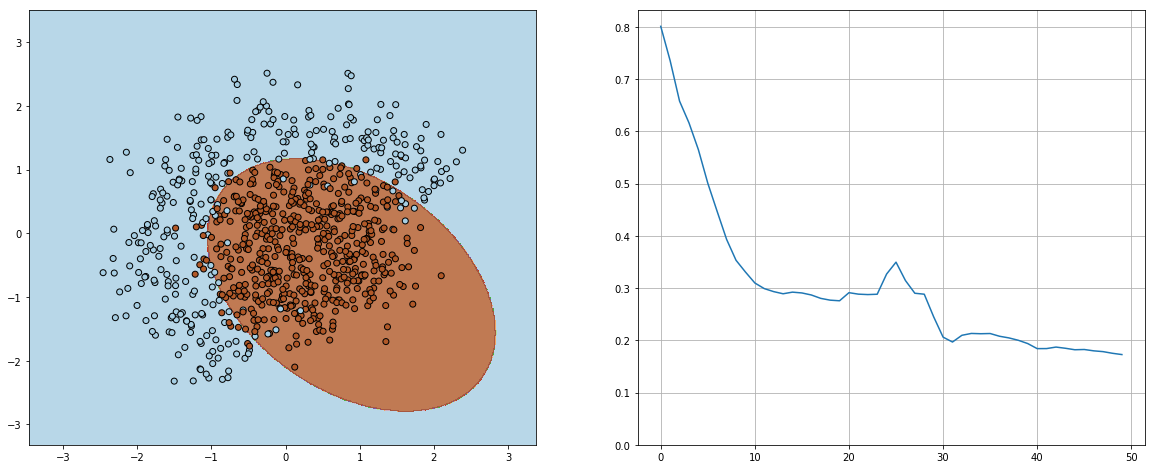

In [12]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)
v = 0.0
c = np.zeros(shape=(6,), dtype=np.float32)

alpha = 0.2 # learning rate
beta = 0.8  # (beta1 coefficient in original paper) exponential decay rate for the 1st moment estimates
mu   = 0.8  # (beta2 coefficient in original paper) exponential decay rate for the 2nd moment estimates
eps = 1e-8  # A small constant for numerical stability

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        
        loss[i] = sess.run(loss_node, feed_dict={X_in: X,
                                                 y_in: y.reshape(1, len(y)),
                                                 w_in: w.reshape(1, 6)})
        
        grad = sess.run(grad_node, feed_dict={X_batch: X[ind, :], 
                                                       y_batch: y[ind].reshape(1, 4),
                                                       w_batch: w.reshape(1, 6)})
        
        v = mu * v + (1 - mu) * grad
        c = beta * c + (1 - beta) * (grad ** 2)
        w = w - alpha * v / (np.sqrt(c + eps))

visualize(X, y, w, loss, n_iter)
plt.clf()